# DualCellQuant Batch Processing

Notebook for batch processing of large numbers of microscopy images

## Processing Flow
1. Load image files
2. Cellpose-SAM Segmentation
3. Apply Target/Reference masks
4. Quantification
5. Radial Profile analysis
6. Peak Difference analysis


## 1. Setup


In [1]:
import os
import sys
import glob
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm



# Import DualCellQuant modules
# Import dualcellquant package from one level up from the test directory
parent_dir = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
sys.path.insert(0, str(parent_dir))

from dualcellquant.core import (
    run_segmentation,
    apply_mask,
    integrate_and_quantify,
)
from dualcellquant.radial import (
    radial_mask,
    radial_profile_all_cells,
    compute_radial_peak_difference,
)
from dualcellquant.tracking import (
    relabel_to_previous,
)
from dualcellquant.visualization import (
    plot_radial_profile_with_peaks,
)

print("Setup completed")
print(f"DualCellQuant path: {parent_dir}")


Setup completed
DualCellQuant path: e:\Data\App\Python\dualCellQuant


In [2]:
# Configure matplotlib for Jupyter Notebook display
%matplotlib inline


## 2. Parameter Configuration


In [25]:

# ========== Segmentation Parameters ==========
SEG_PARAMS = {
    'source': 'reference',  # 'target' or 'reference'
    'channel': 'gray',   # 'gray', 'R', 'G', 'B'
    'diameter': 100,       # 0 = auto
    'flow_threshold': 0.4,
    'cellprob_threshold': 1,
    'use_gpu': True,
    # New: edge-touching cell exclusion control
    'drop_edge_cells': True,
    'inside_fraction_min': 0.98,  # Accept if 98% or more is inside the frame
    'edge_margin_pct': 1.0,       # Margin from edge [%]
}

# ========== Mask Parameters ==========
TARGET_MASK_PARAMS = {
    'channel': 'gray',
    'mode': 'none',  # 'none', 'global_percentile', 'global_otsu', 'per_cell_percentile', 'per_cell_otsu'
    'percentile': 75.0,
    'saturation_limit': 254,
    'min_object_size': 50,
}

REFERENCE_MASK_PARAMS = {
    'channel': 'gray',
    'mode': 'none',
    'percentile': 75.0,
    'saturation_limit': 254,
    'min_object_size': 50,
}

# ========== Radial Mask Parameters ==========
RADIAL_MASK_PARAMS = {
    'inner_pct': 90.0,  # Inner boundary (%, 0=center, 100=cell boundary)
    'outer_pct': 100.0,  # Outer boundary (%)
    'min_object_size': 50,  # Minimum object size
}

# ========== Preprocessing Parameters ==========
PREPROCESS_PARAMS = {
    'bg_enable': True,
    'bg_mode': 'dark_subtract',  # 'rolling', 'dark_subtract', 'manual'
    'bg_radius': 50,
    'bg_dark_pct': 5.0,
    'norm_enable': False,
    'norm_method': 'min-max',  # 'z-score', 'robust z-score', 'min-max', 'percentile [1,99]'
    'manual_tar_bg': None,
    'manual_ref_bg': None,
}

# ========== Quantification Parameters ==========
QUANT_PARAMS = {
    'ratio_epsilon': 1e-6,
    'pixel_width_um': 0.207,
    'pixel_height_um': 0.207,
}

# ========== Radial Profile Parameters ==========
RADIAL_PARAMS = {
    'start_pct': 0.0,
    'end_pct': 150.0,
    'window_size_pct': 5.0,
    'window_step_pct': 1.0,
}

# ========== Peak Difference Parameters ==========
PEAK_PARAMS = {
    'algo': 'first_local_top',  # 'first_local_top', 'global_max'
    'min_pct': 60.0,
    'max_pct': 100.0,
    # New: Savitzky–Golay smoothing and detection sensitivity
    'sg_window': 5,
    'sg_poly': 2,
    'peak_slope_eps_rel': 0.001,
}




In [26]:
# ========== Tracking (ID Maintenance) ==========
TRACKING_PARAMS = {
    'enable': True,           # True to maintain ID across frames within the same sample
    'iou_threshold': 0.05,     # IoU threshold for matching    
}
# ---- Optional prev_labels TIFF settings ----
# mode: 'auto' → Use previous frame results (default) / 'tiff' → Use TIFF at path below
TRACKING_INPUT = {
    'mode': 'tiff',                 # 'auto' or 'tiff'
    'tiff_path': r'E:\Data\App\Python\dualCellQuant\examples\0.0_Z003_cell_masks.tif'  # Example: r"E:\\path\\to\\prev_labels.tif"
}

print("Parameter configuration completed")

# ========== Label TIFF Loading Function ==========
def load_label_tiff(path: str):
    """
    Load label TIFF as np.ndarray(int32).
    Assumes 2D. If 3D, use the first channel.
    """
    try:
        if not path:
            return None
        if not os.path.isfile(path):
            print(f"[WARN] prev_labels TIFF not found: {path}")
            return None
        im = Image.open(path)
        arr = np.array(im)
        if arr.ndim == 3:
            arr = arr[:, :, 0]
        return arr.astype(np.int32, copy=False)
    except Exception as e:
        print(f"[WARN] Failed to load prev_labels TIFF: {e}")
        return None


Parameter configuration completed


## 3. Create Image File List


In [27]:
import urllib.request
import zipfile
import shutil
from pathlib import Path

# Download dataset from Zenodo
# Extract directly to the current directory (same as this notebook)
dataset_url = "https://zenodo.org/records/18321816/files/Fluo-FRB_FKBP12-TM-mApple.zip"
zip_file = Path.cwd() / "Fluo-FRB_FKBP12-TM-mApple.zip"

# Check if ZIP file exists (if not, download it)
if not zip_file.exists():
    print(f"Downloading dataset from Zenodo...")
    print(f"URL: {dataset_url}")
    try:
        urllib.request.urlretrieve(dataset_url, zip_file)
        print(f"✓ Download complete: {zip_file} ({zip_file.stat().st_size / (1024**3):.2f} GB)")
    except Exception as e:
        print(f"✗ Download failed: {e}")
        raise

# Extract ZIP file directly to current directory
print(f"\nExtracting dataset to current directory...")
try:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(Path.cwd())
    print(f"✓ Extraction complete")
    
    # Optional: Delete ZIP file after extraction to save space
    # zip_file.unlink()
    # print(f"✓ Deleted ZIP file: {zip_file}")
except Exception as e:
    print(f"✗ Extraction failed: {e}")
    raise


Extracting dataset to current directory...
✓ Extraction complete


In [28]:
# ========== Input File Settings ==========
# Image directory (recursive search)
INPUT_DIR = r"./Fluo-FRB_FKBP12-TM-mApple"

# Target/Reference identification patterns (regular expressions)
TARGET_PATTERN = r"(\d.+)_C001(Z\d+)\.tif"  # Target image pattern
REFERENCE_PATTERN = r"(\d.+)_C002(Z\d+)\.tif"  # Reference image pattern

# Output directory
OUTPUT_DIR = r"./Fluo-FRB_FKBP12-TM-mApple_Results"

print("Input/Output settings completed")
print(f"Input directory: {INPUT_DIR}")
print(f"Output directory: {OUTPUT_DIR}")


Input/Output settings completed
Input directory: ./Fluo-FRB_FKBP12-TM-mApple
Output directory: ./Fluo-FRB_FKBP12-TM-mApple_Results


In [29]:
import re

# Recursively search for files and create pairs
def find_image_pairs(input_dir, target_pattern, reference_pattern):
    """
    Recursively search for files in the specified directory and
    extract Target/Reference pairs
    """
    target_re = re.compile(target_pattern)
    reference_re = re.compile(reference_pattern)
    
    # Recursively search for all files
    all_files = []
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            full_path = os.path.join(root, file)
            all_files.append(full_path)
    
    print(f"Search completed: {len(all_files)} files found")
    
    # Extract Target files
    target_files = {}
    for path in all_files:
        filename = os.path.basename(path)
        match = target_re.match(filename)
        if match:
            # Group 1: Base name, Group 2: Z number
            base = match.group(1)
            z_num = match.group(2) if len(match.groups()) > 1 else ""
            key = (base, z_num)
            target_files[key] = path
    
    # Extract Reference files
    reference_files = {}
    for path in all_files:
        filename = os.path.basename(path)
        match = reference_re.match(filename)
        if match:
            base = match.group(1)
            z_num = match.group(2) if len(match.groups()) > 1 else ""
            key = (base, z_num)
            reference_files[key] = path
    
    # Create pairs
    pairs = []
    for key in sorted(target_files.keys()):
        if key in reference_files:
            pairs.append((target_files[key], reference_files[key]))
        else:
            print(f"  Warning: No matching Reference found for Target {key}")
    
    # Check for Reference-only files
    for key in reference_files.keys():
        if key not in target_files:
            print(f"  Warning: No matching Target found for Reference {key}")
    
    return pairs

# Auto-detect image pairs
IMAGE_PAIRS = find_image_pairs(INPUT_DIR, TARGET_PATTERN, REFERENCE_PATTERN)

print(f"\nProcessing targets: {len(IMAGE_PAIRS)} image pairs")
for i, (tgt, ref) in enumerate(IMAGE_PAIRS[:5], 1):  # Display first 5 pairs
    print(f"  {i}. Target: {Path(tgt).name}")
    print(f"     Reference: {Path(ref).name}")
if len(IMAGE_PAIRS) > 5:
    print(f"  ... and {len(IMAGE_PAIRS) - 5} more pairs")


Search completed: 96 files found

Processing targets: 32 image pairs
  1. Target: 0.0_C001Z001.tif
     Reference: 0.0_C002Z001.tif
  2. Target: 0.0_C001Z002.tif
     Reference: 0.0_C002Z002.tif
  3. Target: 0.0_C001Z003.tif
     Reference: 0.0_C002Z003.tif
  4. Target: 0.0_C001Z004.tif
     Reference: 0.0_C002Z004.tif
  5. Target: 0.5_C001Z001.tif
     Reference: 0.5_C002Z001.tif
  ... and 27 more pairs


## 4. Create Output Directory


In [30]:
# Create output directory
# Structure:
# Results/
#   ├── sample1/
#   │   ├── masks/
#   │   ├── overlays/
#   │   ├── radial_profile_plots/
#   │   ├── quantification.csv
#   │   ├── radial_profiles.csv
#   │   └── peak_differences.csv
#   ├── sample2/
#   │   └── ...
#   ├── all_samples_quantification.csv
#   └── all_samples_peak_differences.csv

os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory: {OUTPUT_DIR}")


Output directory: ./Fluo-FRB_FKBP12-TM-mApple_Results


## 5. Process Single Image Pair (For Testing)

First, test the processing with one image pair


In [36]:
# Select the first pair for testing
if IMAGE_PAIRS:
    test_target, test_reference = IMAGE_PAIRS[10]
    print(f"Test images:")
    print(f"  Target: {test_target}")
    print(f"  Reference: {test_reference}")
else:
    print("No image pairs found. Please configure IMAGE_PAIRS.")

# Generate base name from filename
def generate_base_name(target_path, target_pattern):
    """
    Generate base_name from Target file path and pattern
    """
    filename = os.path.basename(target_path)
    match = re.match(target_pattern, filename)
    if match:
        # Group 1: Base name, Group 2: Z number
        base = match.group(1)
        z_num = match.group(2) if len(match.groups()) > 1 else ""
        # base_name including Z number
        return f"{base}_{z_num}" if z_num else base
    else:
        # If pattern doesn't match, use filename without extension
        return Path(target_path).stem

base_name = generate_base_name(test_target, TARGET_PATTERN)
print(f"Base name: {base_name}")

# Create output directory for sample
sample_output_dir = os.path.join(OUTPUT_DIR, base_name)


Test images:
  Target: ./Fluo-FRB_FKBP12-TM-mApple\1.0.tif.frames\1.0_C001Z003.tif
  Reference: ./Fluo-FRB_FKBP12-TM-mApple\1.0.tif.frames\1.0_C002Z003.tif
Base name: 1.0_Z003


### Step 1: Load Images


Target image size: (1024, 1024)
Reference image size: (1024, 1024)


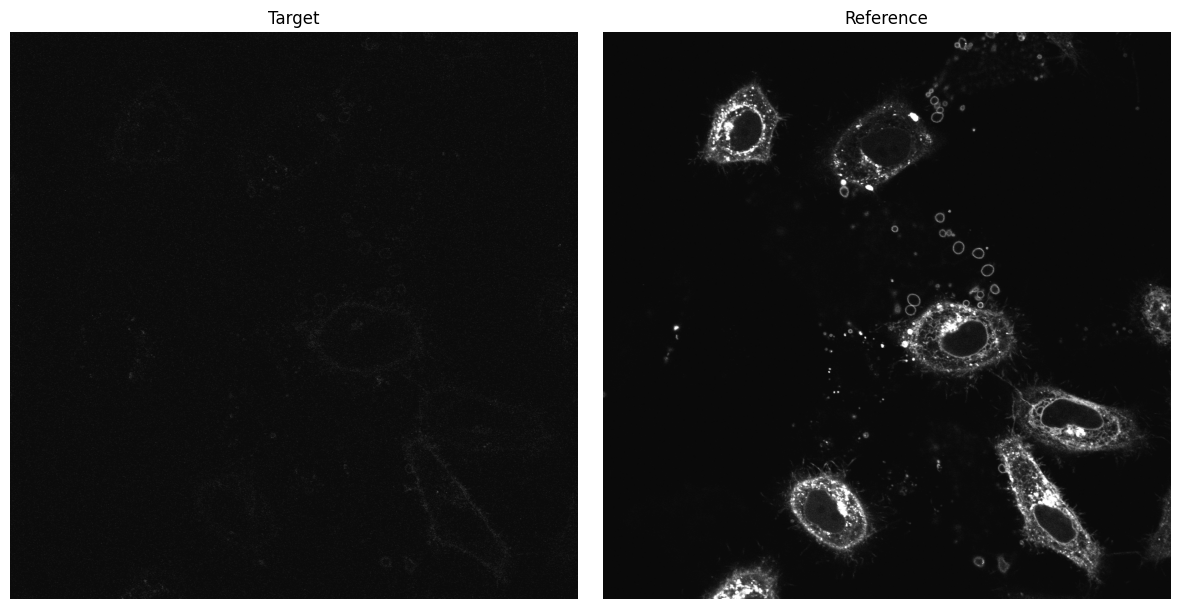

In [35]:
# Load images
target_img = Image.open(test_target)
reference_img = Image.open(test_reference)

# Convert to RGB (if grayscale)
if target_img.mode != 'RGB':
    target_img = target_img.convert('RGB')
if reference_img.mode != 'RGB':
    reference_img = reference_img.convert('RGB')

print(f"Target image size: {target_img.size}")
print(f"Reference image size: {reference_img.size}")

# Display images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(target_img)
axes[0].set_title('Target')
axes[0].axis('off')
axes[1].imshow(reference_img)
axes[1].set_title('Reference')
axes[1].axis('off')
plt.tight_layout()
plt.show()


### Step 2: Cellpose-SAM Segmentation


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
Resizing is deprecated in v4.0.1+


Applied ID maintenance from prev_labels TIFF (6 mappings)
Number of cells detected: 6


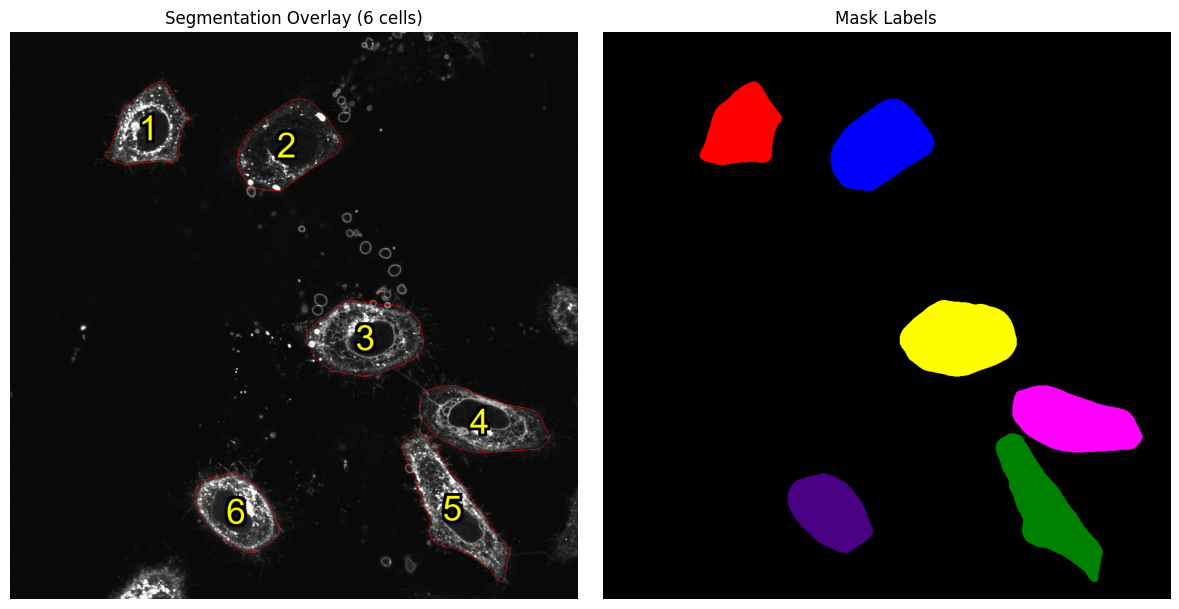

In [37]:
# Run segmentation (with edge exclusion parameters)
seg_overlay, seg_tiff, mask_img, masks = run_segmentation(
    target_img,
    reference_img,
    seg_source=SEG_PARAMS['source'],
    seg_channel=SEG_PARAMS['channel'],
    diameter=SEG_PARAMS['diameter'],
    flow_threshold=SEG_PARAMS['flow_threshold'],
    cellprob_threshold=SEG_PARAMS['cellprob_threshold'],
    use_gpu=SEG_PARAMS['use_gpu'],
    drop_edge_cells=SEG_PARAMS['drop_edge_cells'],
    inside_fraction_min=SEG_PARAMS['inside_fraction_min'],
    edge_margin_pct=SEG_PARAMS['edge_margin_pct'],
)

# Optional: Apply ID maintenance from arbitrary prev_labels TIFF
if TRACKING_PARAMS['enable']:
    prev_labels = None
    if TRACKING_INPUT.get('mode') == 'tiff' and TRACKING_INPUT.get('tiff_path'):
        try:
            prev_labels = load_label_tiff(TRACKING_INPUT['tiff_path'])
        except Exception as e:
            print(f"[WARN] Failed to load prev_labels TIFF: {e}")
        
        if prev_labels is not None:
            # Same preprocessing as UI version: check ndim, dtype, shape
            if prev_labels.ndim != 2:
                prev_labels = np.squeeze(prev_labels)
            prev_labels = prev_labels.astype(np.int32, copy=False)
            curr_masks = masks.astype(np.int32, copy=False)
            
            if prev_labels.shape != curr_masks.shape:
                print(f"[WARN] Ignoring prev_labels TIFF due to size mismatch: {prev_labels.shape} != {curr_masks.shape}")
                prev_labels = None
    # Apply only if prev_labels is provided in single test (auto is applied in batch)
    if prev_labels is not None:
        relabeled, mapping_df, _ = relabel_to_previous(prev_labels, curr_masks, iou_threshold=TRACKING_PARAMS['iou_threshold'])
        masks = relabeled
        print(f"Applied ID maintenance from prev_labels TIFF ({len(mapping_df)} mappings)")

n_cells = len(np.unique(masks)) - 1  # Exclude background
print(f"Number of cells detected: {n_cells}")

# Display segmentation results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(seg_overlay)
axes[0].set_title(f'Segmentation Overlay ({n_cells} cells)')
axes[0].axis('off')
axes[1].imshow(mask_img)
axes[1].set_title('Mask Labels')
axes[1].axis('off')
plt.tight_layout()
plt.show()


### Step 3: Apply Target/Reference Masks


Mask application completed


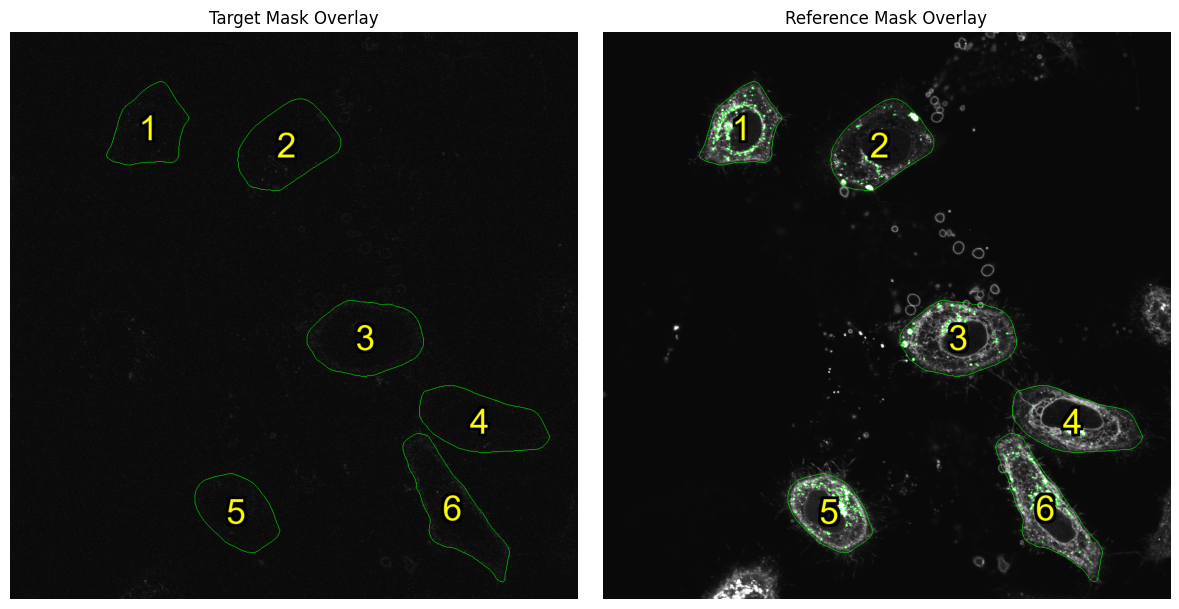

In [38]:
# Apply Target mask
tgt_overlay, tgt_tiff, tgt_mask = apply_mask(
    target_img,
    masks,
    measure_channel=TARGET_MASK_PARAMS['channel'],
    sat_limit=TARGET_MASK_PARAMS['saturation_limit'],
    mask_mode=TARGET_MASK_PARAMS['mode'],
    pct=TARGET_MASK_PARAMS['percentile'],
    min_obj_size=TARGET_MASK_PARAMS['min_object_size'],
    mask_name="target_mask",
)

# Apply Reference mask
ref_overlay, ref_tiff, ref_mask = apply_mask(
    reference_img,
    masks,
    measure_channel=REFERENCE_MASK_PARAMS['channel'],
    sat_limit=REFERENCE_MASK_PARAMS['saturation_limit'],
    mask_mode=REFERENCE_MASK_PARAMS['mode'],
    pct=REFERENCE_MASK_PARAMS['percentile'],
    min_obj_size=REFERENCE_MASK_PARAMS['min_object_size'],
    mask_name="reference_mask",
)

print("Mask application completed")

# Display mask results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(tgt_overlay)
axes[0].set_title('Target Mask Overlay')
axes[0].axis('off')
axes[1].imshow(ref_overlay)
axes[1].set_title('Reference Mask Overlay')
axes[1].axis('off')
plt.tight_layout()
plt.show()


### Step 4: Quantification (Integrate & Quantify)


In [39]:
# Run quantification
result = integrate_and_quantify(
    target_img,
    reference_img,
    masks,
    tgt_mask,
    ref_mask,
    tgt_chan=TARGET_MASK_PARAMS['channel'],
    ref_chan=REFERENCE_MASK_PARAMS['channel'],
    pixel_width_um=QUANT_PARAMS['pixel_width_um'],
    pixel_height_um=QUANT_PARAMS['pixel_height_um'],
    pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
    pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
    pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
    pp_norm_method=PREPROCESS_PARAMS['norm_method'],
    bg_mode=PREPROCESS_PARAMS['bg_mode'],
    bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
    manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
    manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
    ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
)

(
    tgt_and_overlay, ref_and_overlay, and_mask_tiff,
    quant_df, quant_csv,
    tgt_on_and, ref_on_and, ratio_on_and
) = result

print(f"Quantification completed: {len(quant_df)} cells")
print("\nQuantification results (first 5 rows):")
display(quant_df.head())


Quantification completed: 6 cells

Quantification results (first 5 rows):


,label,area_cell_px,area_cell_um2,area_and_px,area_and_um2,sum_target_on_mask,mean_target_on_mask,std_target_on_mask,sum_reference_on_mask,mean_reference_on_mask,...,sum_ratio_T_over_R,mean_ratio_T_over_R,std_ratio_T_over_R,ratio_of_means_on_mask,sum_target_whole,mean_target_whole,std_target_whole,sum_reference_whole,mean_reference_whole,std_reference_whole
0,1,15072,645.820128,14352,614.968848,47959.437500,3.341655,4.958868,8.730779e+05,60.833187,...,1240.177256,0.086411,0.187953,0.054931,52532.257812,3.485420,5.124645,1049465.750,69.630157,61.635727
1,2,20412,874.633788,20034,858.436866,56819.207031,2.836139,4.797797,5.607074e+05,27.987789,...,3370.537354,0.168241,0.407269,0.101335,61083.664062,2.992537,5.050633,653311.000,32.006222,41.895893
2,3,21970,941.392530,21378,916.025922,88906.953125,4.158806,5.822220,1.157280e+06,54.134151,...,2505.733197,0.117211,0.223375,0.076824,94520.015625,4.302231,5.988402,1302310.000,59.276741,53.479969
3,4,20045,858.908205,19835,849.909915,70931.921875,3.576099,5.219948,1.015719e+06,51.208431,...,2425.801589,0.122299,0.254583,0.069834,72308.484375,3.607308,5.250405,1067165.750,53.238503,47.396420
4,5,14938,640.078362,14246,610.426854,45500.664062,3.193926,4.792478,9.930191e+05,69.705116,...,878.314688,0.061653,0.114981,0.045821,50273.101562,3.365451,4.970632,1162547.375,77.824837,60.486652


### Step 5: Radial Mask Quantification

Perform quantification only on the outer ring (radial ring) of cells.


Radial Mask generation completed
  Inner boundary: 90.0%
  Outer boundary: 100.0%

Radial Mask quantification completed: 6 cells

Radial Mask quantification results (first 5 rows):


,label,area_cell_px,area_cell_um2,area_and_px,area_and_um2,sum_target_on_mask,mean_target_on_mask,std_target_on_mask,sum_reference_on_mask,mean_reference_on_mask,...,sum_ratio_T_over_R,mean_ratio_T_over_R,std_ratio_T_over_R,ratio_of_means_on_mask,sum_target_whole,mean_target_whole,std_target_whole,sum_reference_whole,mean_reference_whole,std_reference_whole
0,1,15072,645.820128,2475,106.051275,11187.678711,4.520274,5.623048,101251.703125,40.909779,...,398.422706,0.160979,0.285585,0.110494,52532.257812,3.485420,5.124645,1049465.750,69.630157,61.635727
1,2,20412,874.633788,2885,123.619365,9864.025391,3.419073,5.042314,92314.718750,31.998169,...,466.770119,0.161792,0.308445,0.106852,61083.664062,2.992537,5.050633,653311.000,32.006222,41.895893
2,3,21970,941.392530,3433,147.100617,20614.164062,6.004708,6.974243,141148.000000,41.115059,...,639.400528,0.186251,0.261527,0.146046,94520.015625,4.302231,5.988402,1302310.000,59.276741,53.479969
3,4,20045,858.908205,2832,121.348368,14528.990234,5.130293,6.140778,107849.765625,38.082546,...,562.229428,0.198527,0.316445,0.134715,72308.484375,3.607308,5.250405,1067165.750,53.238503,47.396420
4,5,14938,640.078362,2288,98.038512,8195.591797,3.581990,4.985136,131845.218750,57.624657,...,171.681827,0.075036,0.124484,0.062161,50273.101562,3.365451,4.970632,1162547.375,77.824837,60.486652


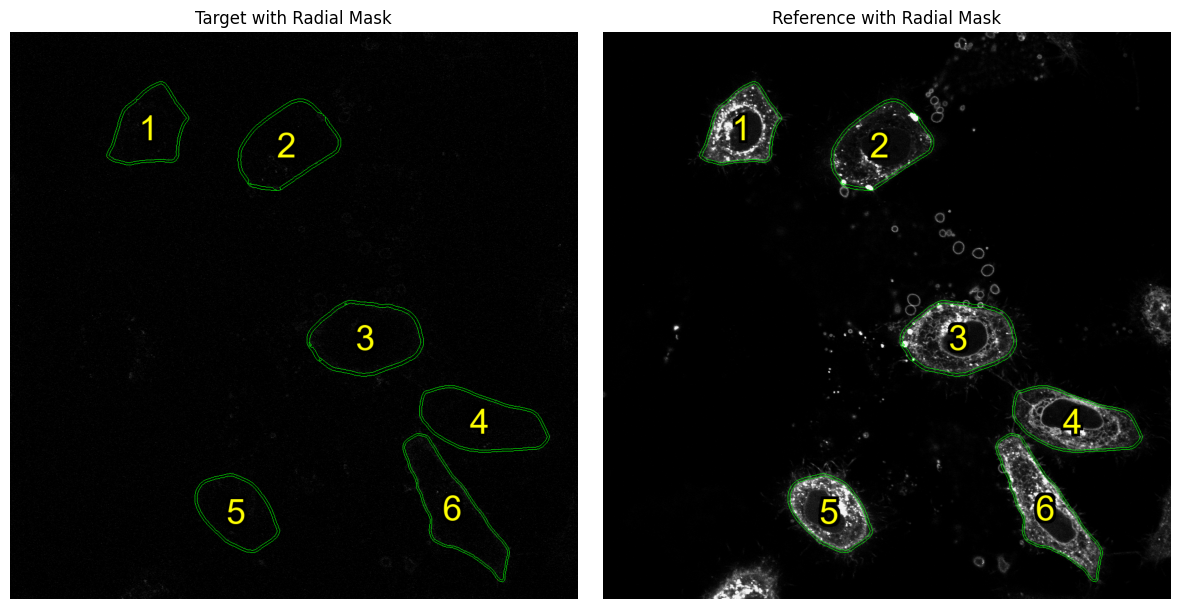

In [40]:


# 1. Generate Radial Mask
radial_overlay, radial_bool_mask, radial_label_mask, radial_bool_tiff, radial_label_tiff = radial_mask(
    masks=masks,
    inner_pct=RADIAL_MASK_PARAMS['inner_pct'],
    outer_pct=RADIAL_MASK_PARAMS['outer_pct'],
    min_obj_size=RADIAL_MASK_PARAMS['min_object_size'],
)

print(f"Radial Mask generation completed")
print(f"  Inner boundary: {RADIAL_MASK_PARAMS['inner_pct']}%")
print(f"  Outer boundary: {RADIAL_MASK_PARAMS['outer_pct']}%")

# # Display Radial Mask
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# axes[0].imshow(radial_overlay)
# axes[0].set_title('Radial Mask Overlay')
# axes[0].axis('off')
# axes[1].imshow(radial_bool_mask, cmap='gray')
# axes[1].set_title('Radial Mask (Boolean)')
# axes[1].axis('off')
# plt.tight_layout()
# plt.show()

# 2. Quantification using Radial Mask
# Use radial mask instead of Target/Reference masks, and specify roi_mask/roi_labels
radial_quant_result = integrate_and_quantify(
    target_img,
    reference_img,
    masks,
    tgt_mask,  # Target mask (normal mask)
    ref_mask,  # Reference mask (normal mask)
    tgt_chan=TARGET_MASK_PARAMS['channel'],
    ref_chan=REFERENCE_MASK_PARAMS['channel'],
    pixel_width_um=QUANT_PARAMS['pixel_width_um'],
    pixel_height_um=QUANT_PARAMS['pixel_height_um'],
    pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
    pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
    pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
    pp_norm_method=PREPROCESS_PARAMS['norm_method'],
    bg_mode=PREPROCESS_PARAMS['bg_mode'],
    bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
    manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
    manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
    ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
    roi_mask=radial_bool_mask,  # Specify Radial Mask as ROI
    roi_labels=radial_label_mask,  # Specify Radial Labels as ROI labels
)

(
    radial_tgt_and_overlay, radial_ref_and_overlay, radial_and_mask_tiff,
    radial_quant_df, radial_quant_csv,
    radial_tgt_on_and, radial_ref_on_and, radial_ratio_on_and
) = radial_quant_result

print(f"\nRadial Mask quantification completed: {len(radial_quant_df)} cells")
print("\nRadial Mask quantification results (first 5 rows):")
display(radial_quant_df.head())

# Display overlay images with Radial Mask applied
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(radial_tgt_and_overlay)
axes[0].set_title('Target with Radial Mask')
axes[0].axis('off')
axes[1].imshow(radial_ref_and_overlay)
axes[1].set_title('Reference with Radial Mask')
axes[1].axis('off')
plt.tight_layout()
plt.show()


### Step 6: Radial Profile Analysis


In [41]:
# Run Radial Profile analysis
radial_df, radial_csv = radial_profile_all_cells(
    target_img,
    reference_img,
    masks,
    tgt_chan=TARGET_MASK_PARAMS['channel'],
    ref_chan=REFERENCE_MASK_PARAMS['channel'],
    start_pct=RADIAL_PARAMS['start_pct'],
    end_pct=RADIAL_PARAMS['end_pct'],
    window_size_pct=RADIAL_PARAMS['window_size_pct'],
    window_step_pct=RADIAL_PARAMS['window_step_pct'],
    pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
    pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
    pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
    pp_norm_method=PREPROCESS_PARAMS['norm_method'],
    bg_mode=PREPROCESS_PARAMS['bg_mode'],
    bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
    manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
    manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
    ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
)

print(f"Radial Profile analysis completed: {len(radial_df)} data points")
print("\nRadial Profile results (first 5 rows):")
display(radial_df.head())


Radial Profile analysis completed: 876 data points

Radial Profile results (first 5 rows):


,label,band_start_pct,band_end_pct,center_pct,count_px,mean_target,mean_reference,std_target,std_reference,sem_target,sem_reference,mean_ratio_T_over_R,std_ratio_T_over_R,sem_ratio_T_over_R,count_ratio_px
0,1,0.0,5.0,2.5,71,0.928123,13.597798,1.976512,4.709935,0.234569,0.558966,0.074830,0.156091,0.018525,71
1,1,1.0,6.0,3.5,89,1.372173,13.994973,3.244478,5.183579,0.343914,0.549458,0.100742,0.204185,0.021644,89
2,1,2.0,7.0,4.5,106,1.456156,14.317497,3.215947,5.250077,0.312360,0.509933,0.104970,0.202607,0.019679,106
3,1,3.0,8.0,5.5,130,1.820415,14.367710,3.327017,5.438340,0.291799,0.476974,0.145804,0.272164,0.023870,130
4,1,4.0,9.0,6.5,151,1.886889,14.542578,3.346912,5.570529,0.272368,0.453323,0.163412,0.325857,0.026518,151


### Step 7: Peak Difference Analysis


In [42]:
# Run Peak Difference analysis (SG + first_local_top support)
peak_df = compute_radial_peak_difference(
    radial_df,
    quant_df=quant_df,
    algo=PEAK_PARAMS['algo'],
    min_pct=PEAK_PARAMS['min_pct'],
    max_pct=PEAK_PARAMS['max_pct'],
    sg_window=PEAK_PARAMS['sg_window'],
    sg_poly=PEAK_PARAMS['sg_poly'],
    peak_slope_eps_rel=PEAK_PARAMS['peak_slope_eps_rel'],
)

print(f"Peak Difference analysis completed: {len(peak_df)} cells")
print("\nPeak Difference results:")
display(peak_df)

# Statistical information
if not peak_df.empty and 'difference_pct' in peak_df.columns:
    print(f"\nPeak Difference statistics:")
    print(f"  Mean: {peak_df['difference_pct'].mean():.2f} %")
    print(f"  Median: {peak_df['difference_pct'].median():.2f} %")
    print(f"  Std Dev: {peak_df['difference_pct'].std():.2f} %")


Peak Difference analysis completed: 6 cells

Peak Difference results:


,label,max_target_center_pct,max_reference_center_pct,difference_pct,max_target_px,max_reference_px,difference_px,max_target_um,max_reference_um,difference_um,max_target_intensity,max_reference_intensity,ratio_intensity,ref_range_rel,ref_noise_rel,ref_neg_run_after_peak,accept_ref
0,1,91.5,88.5,3.0,63.376989,61.299055,2.077934,13.119037,12.688904,0.430132,5.357694,76.779341,0.069780,0.836664,0.020382,0,False
1,2,89.5,87.5,2.0,72.142449,70.530327,1.612122,14.933487,14.599778,0.333709,4.434627,61.895991,0.071646,0.639981,0.033086,12,True
2,3,87.5,84.5,3.0,73.172542,70.663770,2.508773,15.146716,14.627400,0.519316,8.142289,86.536969,0.094090,0.712555,0.040212,15,True
3,4,93.5,80.5,13.0,74.686087,64.301925,10.384162,15.460020,13.310498,2.149521,5.185324,64.366893,0.080559,0.687552,0.031278,2,True
4,5,88.5,85.5,3.0,61.025952,58.957275,2.068676,12.632372,12.204156,0.428216,4.901467,128.627864,0.038106,0.723286,0.028845,0,False
5,6,90.5,82.5,8.0,73.356569,66.872010,6.484559,15.184810,13.842506,1.342304,11.633799,112.177975,0.103708,0.745255,0.018477,17,True



Peak Difference statistics:
  Mean: 5.33 %
  Median: 3.00 %
  Std Dev: 4.32 %


### Step 7-1: Generate Radial Profile Graphs (All Labels)



Generating Radial Profile graphs for 6 cells...


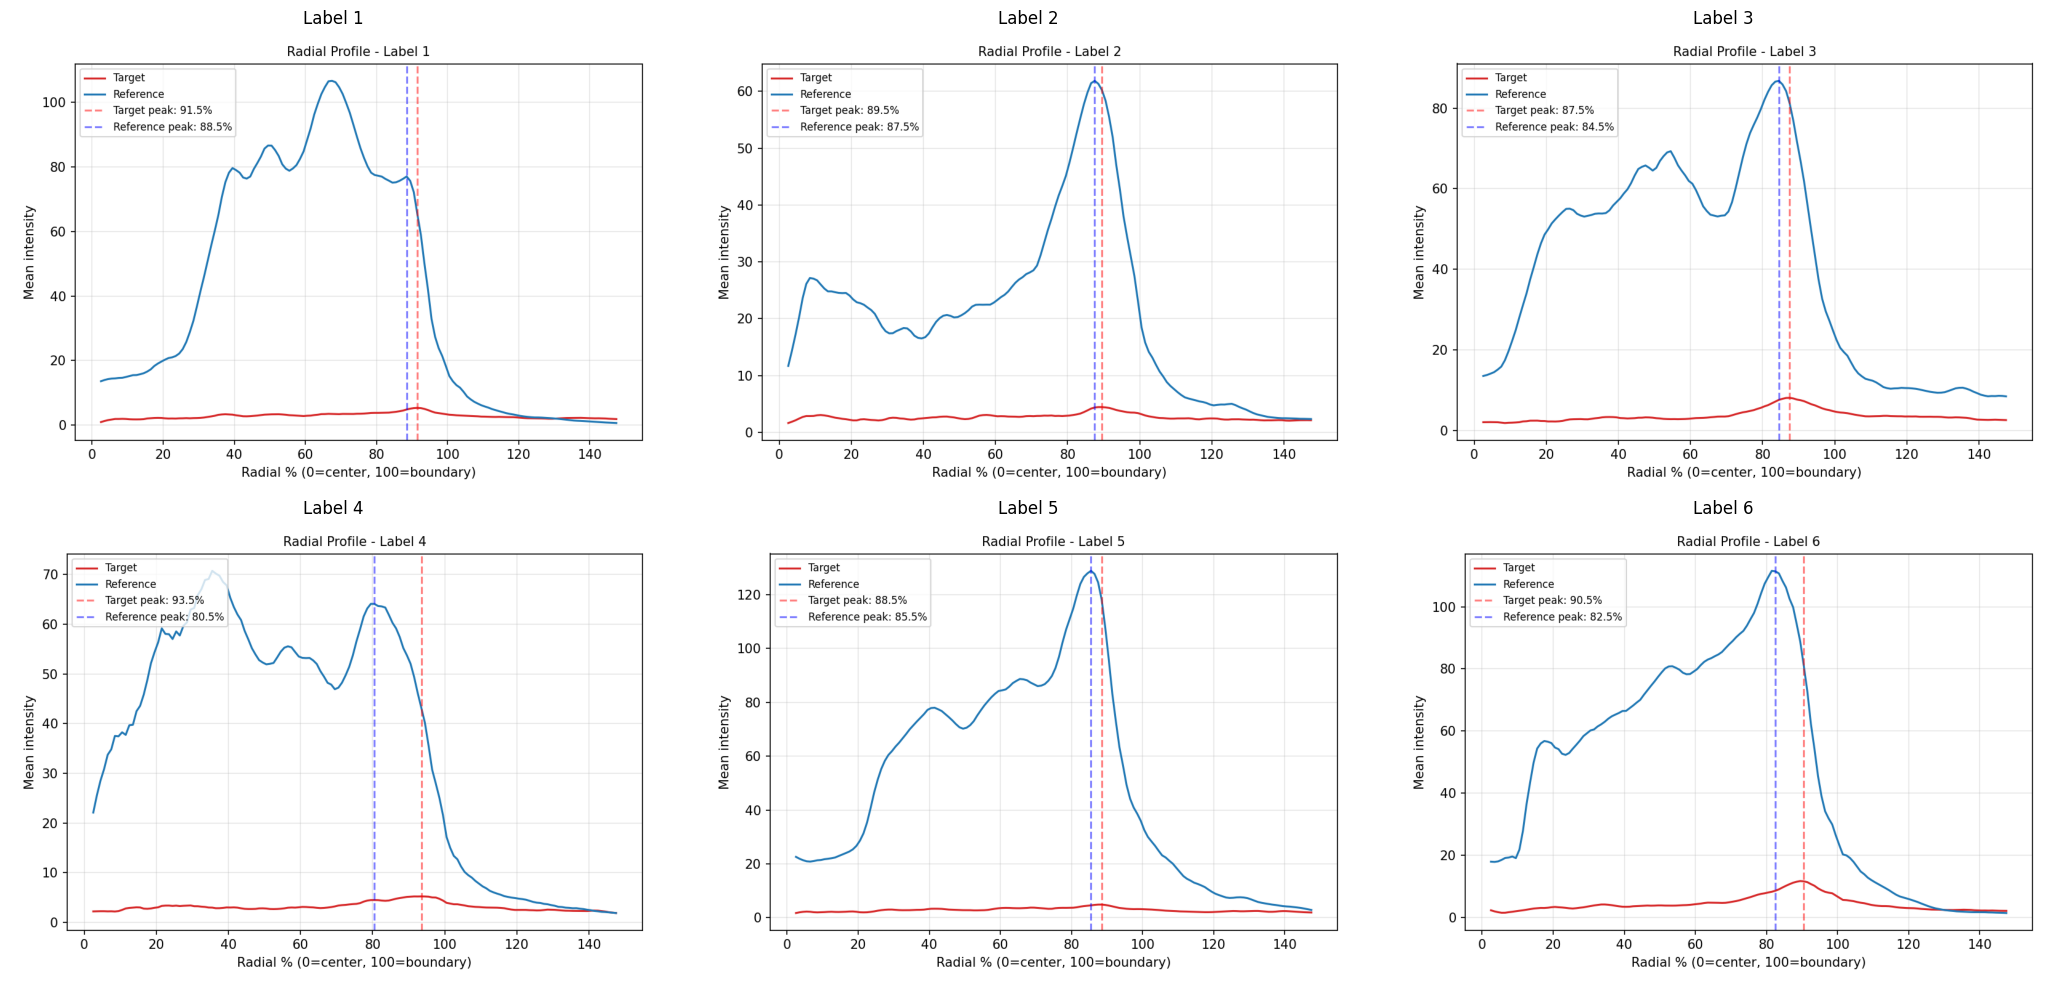

In [43]:
# Generate Radial Profile graphs for all labels (T/R not displayed)
if not radial_df.empty and not peak_df.empty:
    # Get unique labels
    unique_labels = sorted(radial_df['label'].unique())
    
    print(f"\nGenerating Radial Profile graphs for {len(unique_labels)} cells...")
    
    
    # Display all graphs in 3 columns
    
    if unique_labels:
        n_column = 3
        n_row = (len(unique_labels) + n_column - 1) // n_column
        
        fig, axes = plt.subplots(n_row, n_column, figsize=(7 * n_column, 5 * n_row))
        axes = axes.flatten()  # Convert 2D array to 1D

        for i, label in enumerate(unique_labels):
            plot_img = plot_radial_profile_with_peaks(
                df=radial_df,
                peak_df=peak_df,
                label_filter=label,
                window_bins=1,
                show_errorbars=False,
                show_ratio=False,
            )
            axes[i].imshow(plot_img)
            axes[i].axis('off')
            axes[i].set_title(f'Label {label}', fontsize=12)
        
        plt.tight_layout()
        plt.show()
else:
    print("No Radial Profile or Peak Difference data available")


### Save Results (For Testing)


In [44]:


os.makedirs(sample_output_dir, exist_ok=True)
os.makedirs(os.path.join(sample_output_dir, "masks"), exist_ok=True)
os.makedirs(os.path.join(sample_output_dir, "overlays"), exist_ok=True)
os.makedirs(os.path.join(sample_output_dir, "radial_profile_plots"), exist_ok=True)

# Save CSV files
quant_output = os.path.join(sample_output_dir, "quantification.csv")
quant_df.to_csv(quant_output, index=False)
print(f"Saved quantification results: {quant_output}")

radial_output = os.path.join(sample_output_dir, "radial_profiles.csv")
radial_df.to_csv(radial_output, index=False)
print(f"Saved Radial Profile results: {radial_output}")

peak_output = os.path.join(sample_output_dir, "peak_differences.csv")
peak_df.to_csv(peak_output, index=False)
print(f"Saved Peak Difference results: {peak_output}")

# Save Radial Mask quantification results (if available)
if radial_quant_df is not None:
    radial_quant_output = os.path.join(sample_output_dir, "radial_mask_quantification.csv")
    radial_quant_df.to_csv(radial_quant_output, index=False)
    print(f"Saved Radial Mask quantification results: {radial_quant_output}")

# Save overlay images
seg_overlay.save(os.path.join(sample_output_dir, "overlays", "segmentation_overlay.png"))
tgt_overlay.save(os.path.join(sample_output_dir, "overlays", "target_mask_overlay.png"))
ref_overlay.save(os.path.join(sample_output_dir, "overlays", "reference_mask_overlay.png"))

# Save Radial Mask overlay (if available)
if radial_overlay is not None:
    radial_overlay.save(os.path.join(sample_output_dir, "overlays", "radial_mask_overlay.png"))

# Save mask TIFFs
Image.fromarray(masks.astype(np.uint16)).save(os.path.join(sample_output_dir, "masks", "cell_masks.tif"))

# Save Radial Mask (if available)
if radial_bool_mask is not None:
    Image.fromarray((radial_bool_mask * 255).astype(np.uint8)).save(os.path.join(sample_output_dir, "masks", "radial_mask.tif"))

# Save Radial Profile graphs
if not radial_df.empty and not peak_df.empty:
    for label in unique_labels:
        plot_img = plot_radial_profile_with_peaks(
            df=radial_df,
            peak_df=peak_df,
            label_filter=label,
            window_bins=1,
            show_errorbars=False,
            show_ratio=False,
        )
        plot_path = os.path.join(sample_output_dir, "radial_profile_plots", f"radial_profile_label_{label}.png")
        plot_img.save(plot_path)
        print(f"Saved Radial Profile graph: {plot_path}")

print(f"\nAll results saved to: {sample_output_dir}")


Saved quantification results: ./Fluo-FRB_FKBP12-TM-mApple_Results\1.0_Z003\quantification.csv
Saved Radial Profile results: ./Fluo-FRB_FKBP12-TM-mApple_Results\1.0_Z003\radial_profiles.csv
Saved Peak Difference results: ./Fluo-FRB_FKBP12-TM-mApple_Results\1.0_Z003\peak_differences.csv
Saved Radial Mask quantification results: ./Fluo-FRB_FKBP12-TM-mApple_Results\1.0_Z003\radial_mask_quantification.csv
Saved Radial Profile graph: ./Fluo-FRB_FKBP12-TM-mApple_Results\1.0_Z003\radial_profile_plots\radial_profile_label_1.png
Saved Radial Profile graph: ./Fluo-FRB_FKBP12-TM-mApple_Results\1.0_Z003\radial_profile_plots\radial_profile_label_2.png
Saved Radial Profile graph: ./Fluo-FRB_FKBP12-TM-mApple_Results\1.0_Z003\radial_profile_plots\radial_profile_label_3.png
Saved Radial Profile graph: ./Fluo-FRB_FKBP12-TM-mApple_Results\1.0_Z003\radial_profile_plots\radial_profile_label_4.png
Saved Radial Profile graph: ./Fluo-FRB_FKBP12-TM-mApple_Results\1.0_Z003\radial_profile_plots\radial_profile_lab

## 6. Batch Processing (All Image Pairs)

If the test above is successful, batch process all image pairs


In [45]:
# Batch processing function (ID maintenance + SG + first_local_top peak analysis support)
def process_image_pair(target_path, reference_path, output_dir, target_pattern, prev_labels=None):
    """
    Function to process one image pair
    prev_labels: Labels from previous frame (for ID maintenance) / None
    Returns: dict with keys including 'masks' (after relabeling)
    """
    try:
        # Generate base_name
        base_name = generate_base_name(target_path, target_pattern)
        
        # Create output directory for sample
        sample_output_dir = os.path.join(output_dir, base_name)
        os.makedirs(sample_output_dir, exist_ok=True)
        os.makedirs(os.path.join(sample_output_dir, "masks"), exist_ok=True)
        os.makedirs(os.path.join(sample_output_dir, "overlays"), exist_ok=True)
        os.makedirs(os.path.join(sample_output_dir, "radial_profile_plots"), exist_ok=True)
        
        # Initialize variables
        rad_overlay = None
        rad_bool_mask = None
        rad_label_mask = None
        radial_tar_overlay = None
        radial_ref_overlay = None
        radial_quant_df = None
        
        # 1. Load images
        target_img = Image.open(target_path)
        reference_img = Image.open(reference_path)
        if target_img.mode != 'RGB':
            target_img = target_img.convert('RGB')
        if reference_img.mode != 'RGB':
            reference_img = reference_img.convert('RGB')
        
        # 2. Segmentation (apply edge exclusion options)
        seg_overlay, seg_tiff, mask_img, masks_raw = run_segmentation(
            target_img,
            reference_img,
            seg_source=SEG_PARAMS['source'],
            seg_channel=SEG_PARAMS['channel'],
            diameter=SEG_PARAMS['diameter'],
            flow_threshold=SEG_PARAMS['flow_threshold'],
            cellprob_threshold=SEG_PARAMS['cellprob_threshold'],
            use_gpu=SEG_PARAMS['use_gpu'],
            drop_edge_cells=SEG_PARAMS['drop_edge_cells'],
            inside_fraction_min=SEG_PARAMS['inside_fraction_min'],
            edge_margin_pct=SEG_PARAMS['edge_margin_pct'],
        )
        masks = masks_raw.copy()
        n_cells = len(np.unique(masks)) - 1

        # 2.1 ID maintenance (IoU match if previous frame exists and is valid)
        if TRACKING_PARAMS['enable'] and prev_labels is not None:
            # Same preprocessing as UI version
            prev_arr = prev_labels.astype(np.int32, copy=False)
            curr = masks.astype(np.int32, copy=False)
            
            if prev_arr.shape == curr.shape:
                relabeled, mapping_df, _ = relabel_to_previous(prev_arr, curr, iou_threshold=TRACKING_PARAMS['iou_threshold'])
                masks = relabeled  # Overwrite
                # Save mapping information
                mapping_csv = os.path.join(sample_output_dir, f"{base_name}_id_mapping.csv")
                mapping_df.to_csv(mapping_csv, index=False)
        
        # 3. Apply masks
        tgt_overlay, tgt_tiff, tgt_mask = apply_mask(
            target_img, masks,
            measure_channel=TARGET_MASK_PARAMS['channel'],
            sat_limit=TARGET_MASK_PARAMS['saturation_limit'],
            mask_mode=TARGET_MASK_PARAMS['mode'],
            pct=TARGET_MASK_PARAMS['percentile'],
            min_obj_size=TARGET_MASK_PARAMS['min_object_size'],
            mask_name="target_mask",
        )
        ref_overlay, ref_tiff, ref_mask = apply_mask(
            reference_img, masks,
            measure_channel=REFERENCE_MASK_PARAMS['channel'],
            sat_limit=REFERENCE_MASK_PARAMS['saturation_limit'],
            mask_mode=REFERENCE_MASK_PARAMS['mode'],
            pct=REFERENCE_MASK_PARAMS['percentile'],
            min_obj_size=REFERENCE_MASK_PARAMS['min_object_size'],
            mask_name="reference_mask",
        )
        
        # 4. Quantification
        result = integrate_and_quantify(
            target_img, reference_img, masks, tgt_mask, ref_mask,
            tgt_chan=TARGET_MASK_PARAMS['channel'],
            ref_chan=REFERENCE_MASK_PARAMS['channel'],
            pixel_width_um=QUANT_PARAMS['pixel_width_um'],
            pixel_height_um=QUANT_PARAMS['pixel_height_um'],
            pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
            pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
            pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
            pp_norm_method=PREPROCESS_PARAMS['norm_method'],
            bg_mode=PREPROCESS_PARAMS['bg_mode'],
            bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
            manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
            manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
            ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
        )
        quant_df = result[3]
        
        # 5. Radial Mask quantification
        rad_overlay, rad_bool_mask, rad_label_mask, rad_bool_tiff, rad_label_tiff = radial_mask(
            masks=masks,
            inner_pct=RADIAL_MASK_PARAMS['inner_pct'],
            outer_pct=RADIAL_MASK_PARAMS['outer_pct'],
            min_obj_size=RADIAL_MASK_PARAMS['min_object_size'],
        )
        radial_quant_result = integrate_and_quantify(
            target_img, reference_img, masks, tgt_mask, ref_mask,
            tgt_chan=TARGET_MASK_PARAMS['channel'],
            ref_chan=REFERENCE_MASK_PARAMS['channel'],
            pixel_width_um=QUANT_PARAMS['pixel_width_um'],
            pixel_height_um=QUANT_PARAMS['pixel_height_um'],
            pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
            pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
            pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
            pp_norm_method=PREPROCESS_PARAMS['norm_method'],
            bg_mode=PREPROCESS_PARAMS['bg_mode'],
            bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
            manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
            manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
            ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
            roi_mask=rad_bool_mask,
            roi_labels=rad_label_mask,
        )
        radial_tar_overlay = radial_quant_result[0]
        radial_ref_overlay = radial_quant_result[1]
        radial_quant_df = radial_quant_result[3]
        
        # 6. Radial Profile (RAW) analysis
        radial_df_raw, radial_csv_raw = radial_profile_all_cells(
            target_img, reference_img, masks,
            tgt_chan=TARGET_MASK_PARAMS['channel'],
            ref_chan=REFERENCE_MASK_PARAMS['channel'],
            start_pct=RADIAL_PARAMS['start_pct'],
            end_pct=RADIAL_PARAMS['end_pct'],
            window_size_pct=RADIAL_PARAMS['window_size_pct'],
            window_step_pct=RADIAL_PARAMS['window_step_pct'],
            pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
            pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
            pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
            pp_norm_method=PREPROCESS_PARAMS['norm_method'],
            bg_mode=PREPROCESS_PARAMS['bg_mode'],
            bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
            manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
            manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
            ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
        )
        
        # 7. Peak Difference (SG smoothing + first_local_top configurable)
        peak_df = compute_radial_peak_difference(
            radial_df_raw,
            quant_df=quant_df,
            min_pct=PEAK_PARAMS['min_pct'],
            max_pct=PEAK_PARAMS['max_pct'],
            algo=PEAK_PARAMS['algo'],
            sg_window=PEAK_PARAMS['sg_window'],
            sg_poly=PEAK_PARAMS['sg_poly'],
            peak_slope_eps_rel=PEAK_PARAMS['peak_slope_eps_rel'],
        )
        peak_csv = os.path.join(sample_output_dir, f"{base_name}_peak_differences.csv")
        peak_df.to_csv(peak_csv, index=False)

        # Save results (CSV files) - prefix with base_name
        quant_df.to_csv(os.path.join(sample_output_dir, f"{base_name}_quantification.csv"), index=False)
        radial_df_raw.to_csv(os.path.join(sample_output_dir, f"{base_name}_radial_profiles_raw.csv"), index=False)
        if radial_quant_df is not None:
            radial_quant_df.to_csv(os.path.join(sample_output_dir, f"{base_name}_radial_mask_quantification.csv"), index=False)
        
        # Save overlay images - prefix with base_name
        seg_overlay.save(os.path.join(sample_output_dir, "overlays", f"{base_name}_segmentation_overlay.png"))
        tgt_overlay.save(os.path.join(sample_output_dir, "overlays", f"{base_name}_target_mask_overlay.png"))
        ref_overlay.save(os.path.join(sample_output_dir, "overlays", f"{base_name}_reference_mask_overlay.png"))
        if rad_overlay is not None:
            rad_overlay.save(os.path.join(sample_output_dir, "overlays", f"{base_name}_radial_mask_overlay.png"))
        if radial_tar_overlay is not None:
            radial_tar_overlay.save(os.path.join(sample_output_dir, "overlays", f"{base_name}_target_radial_overlay.png"))
        if radial_ref_overlay is not None:
            radial_ref_overlay.save(os.path.join(sample_output_dir, "overlays", f"{base_name}_reference_radial_overlay.png"))

        # Save mask TIFFs
        Image.fromarray(masks.astype(np.uint16)).save(os.path.join(sample_output_dir, "masks", f"{base_name}_cell_masks.tif"))
        if tgt_mask is not None and tgt_mask.any():
            Image.fromarray((tgt_mask * 255).astype(np.uint8)).save(os.path.join(sample_output_dir, "masks", f"{base_name}_target_mask.tif"))
        if ref_mask is not None and ref_mask.any():
            Image.fromarray((ref_mask * 255).astype(np.uint8)).save(os.path.join(sample_output_dir, "masks", f"{base_name}_reference_mask.tif"))
        if rad_bool_mask is not None:
            Image.fromarray((rad_bool_mask * 255).astype(np.uint8)).save(os.path.join(sample_output_dir, "masks", f"{base_name}_radial_mask.tif"))

        # Generate Radial Profile plots (peak difference line can be added later)
        unique_labels = sorted(radial_df_raw['label'].unique()) if not radial_df_raw.empty else []
        for label in unique_labels:
            plot_img = plot_radial_profile_with_peaks(
                df=radial_df_raw,
                peak_df=peak_df,
                label_filter=label,
                window_bins=1,
                show_errorbars=False,
                show_ratio=False,
            )
            plot_path = os.path.join(sample_output_dir, "radial_profile_plots", f"{base_name}_label{label}_radial_profile.png")
            plot_img.save(plot_path)

        return {
            'base_name': base_name,
            'n_cells': n_cells,
            'status': 'success',
            'quant_df': quant_df,
            'radial_df': radial_df_raw,
            'peak_df': peak_df,
            'radial_quant_df': radial_quant_df,
            'sample_dir': sample_output_dir,
            'masks': masks,  # Masks after relabeling
        }
        
    except Exception as e:
        import traceback
        return {
            'base_name': Path(target_path).stem,
            'status': 'error',
            'error': str(e),
            'traceback': traceback.format_exc(),
        }

print("Batch processing function updated (ID maintenance + SG + First Local Top support)")


Batch processing function updated (ID maintenance + SG + First Local Top support)


In [46]:
# Execute batch processing (maintain ID across frames within the same sample)
results = []
errors = []

print(f"\nStarting processing of {len(IMAGE_PAIRS)} image pairs...\n")

import re

def parse_base_and_z_from_target_path(target_path, target_pattern):
    fn = os.path.basename(target_path)
    m = re.match(target_pattern, fn)
    if m:
        base = m.group(1)
        znum = m.group(2) if len(m.groups()) > 1 else ""
        return base, znum
    return Path(target_path).stem, ""

# Group by base: sort Z slices for each base
from collections import defaultdict
by_base = defaultdict(list)
for tgt, ref in IMAGE_PAIRS:
    base, z = parse_base_and_z_from_target_path(tgt, TARGET_PATTERN)
    by_base[base].append((z, tgt, ref))

# Seed prev_labels for first frame from external TIFF (optional)
prev_labels_seed = None
if TRACKING_PARAMS['enable'] and TRACKING_INPUT.get('mode') == 'tiff' and TRACKING_INPUT.get('tiff_path'):
    prev_labels_seed = load_label_tiff(TRACKING_INPUT['tiff_path'])
    if prev_labels_seed is None:
        print("[INFO] prev_labels TIFF not used (not specified or failed to load).")

# Sort in Z ascending order (Z001, Z002, ... dictionary order is OK)
for base, items in by_base.items():
    items_sorted = sorted(items, key=lambda x: x[0])
    prev_labels = prev_labels_seed  # Apply seed to first frame of each base
    print(f"\n== Sample: {base} / Number of frames: {len(items_sorted)} ==")
    for i, (z, target_path, reference_path) in enumerate(items_sorted, 1):
        print(f"  [{i}/{len(items_sorted)}] Processing: {Path(target_path).name}")
        # Discard seed if shape mismatch (first frame only) + same preprocessing as UI version
        if prev_labels is not None:
            try:
                tmp_img = Image.open(target_path)
                if tmp_img.mode != 'RGB':
                    tmp_img = tmp_img.convert('RGB')
                H, W = tmp_img.size[1], tmp_img.size[0]
                
                # Same np.squeeze processing as UI version
                if prev_labels.ndim != 2:
                    prev_labels = np.squeeze(prev_labels)
                prev_labels = prev_labels.astype(np.int32, copy=False)
                
                if prev_labels.shape != (H, W):
                    print(f"    [WARN] Ignoring prev_labels seed due to size mismatch: {prev_labels.shape} != {(H,W)}")
                    prev_labels = None
            except Exception:
                prev_labels = None
        result = process_image_pair(
            target_path, reference_path, OUTPUT_DIR, TARGET_PATTERN,
            prev_labels=prev_labels if TRACKING_PARAMS['enable'] else None
        )
        if result['status'] == 'success':
            print(f"    ✓ Success: {result['n_cells']} cells detected → {result['sample_dir']}")
            results.append(result)
            prev_labels = result.get('masks', None)  # Pass to next frame
        else:
            print(f"    ✗ Error: {result['error']}")
            errors.append(result)

print(f"\n\nProcessing complete: {len(results)} success, {len(errors)} errors")


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used



Starting processing of 32 image pairs...


== Sample: 0.0 / Number of frames: 4 ==
  [1/4] Processing: 0.0_C001Z001.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 6 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\0.0_Z001
  [2/4] Processing: 0.0_C001Z002.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 6 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\0.0_Z002
  [3/4] Processing: 0.0_C001Z003.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 6 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\0.0_Z003
  [4/4] Processing: 0.0_C001Z004.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 6 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\0.0_Z004

== Sample: 0.5 / Number of frames: 4 ==
  [1/4] Processing: 0.5_C001Z001.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 6 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\0.5_Z001
  [2/4] Processing: 0.5_C001Z002.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 6 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\0.5_Z002
  [3/4] Processing: 0.5_C001Z003.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 6 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\0.5_Z003
  [4/4] Processing: 0.5_C001Z004.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 6 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\0.5_Z004

== Sample: 1.0 / Number of frames: 4 ==
  [1/4] Processing: 1.0_C001Z001.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 6 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\1.0_Z001
  [2/4] Processing: 1.0_C001Z002.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 6 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\1.0_Z002
  [3/4] Processing: 1.0_C001Z003.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 7 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\1.0_Z003
  [4/4] Processing: 1.0_C001Z004.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 6 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\1.0_Z004

== Sample: 10 / Number of frames: 4 ==
  [1/4] Processing: 10_C001Z001.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 5 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\10_Z001
  [2/4] Processing: 10_C001Z002.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 5 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\10_Z002
  [3/4] Processing: 10_C001Z003.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 5 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\10_Z003
  [4/4] Processing: 10_C001Z004.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 4 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\10_Z004

== Sample: 2.0 / Number of frames: 4 ==
  [1/4] Processing: 2.0_C001Z001.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 5 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\2.0_Z001
  [2/4] Processing: 2.0_C001Z002.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 5 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\2.0_Z002
  [3/4] Processing: 2.0_C001Z003.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 5 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\2.0_Z003
  [4/4] Processing: 2.0_C001Z004.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 6 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\2.0_Z004

== Sample: 20 / Number of frames: 4 ==
  [1/4] Processing: 20_C001Z001.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 4 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\20_Z001
  [2/4] Processing: 20_C001Z002.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 4 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\20_Z002
  [3/4] Processing: 20_C001Z003.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 4 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\20_Z003
  [4/4] Processing: 20_C001Z004.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 5 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\20_Z004

== Sample: 30 / Number of frames: 4 ==
  [1/4] Processing: 30_C001Z001.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 5 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\30_Z001
  [2/4] Processing: 30_C001Z002.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 4 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\30_Z002
  [3/4] Processing: 30_C001Z003.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 4 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\30_Z003
  [4/4] Processing: 30_C001Z004.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 4 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\30_Z004

== Sample: 5.0 / Number of frames: 4 ==
  [1/4] Processing: 5.0_C001Z001.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 5 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\5.0_Z001
  [2/4] Processing: 5.0_C001Z002.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 5 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\5.0_Z002
  [3/4] Processing: 5.0_C001Z003.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 5 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\5.0_Z003
  [4/4] Processing: 5.0_C001Z004.tif


Resizing is deprecated in v4.0.1+


    ✓ Success: 5 cells detected → ./Fluo-FRB_FKBP12-TM-mApple_Results\5.0_Z004


Processing complete: 32 success, 0 errors


## 7. Create Overall Summary


In [47]:
# Consolidate quantification results from all samples
all_quant_dfs = []
for res in results:
    df = res['quant_df'].copy()
    df.insert(0, 'sample_name', res['base_name'])
    all_quant_dfs.append(df)

if all_quant_dfs:
    combined_quant = pd.concat(all_quant_dfs, ignore_index=True)
    
    # Extract additive and Z from sample_name
    # Pattern: "4h.[additive]_Z[Z]" → additive:float, Z:int
    def parse_sample_name(name):
        import re
        # Example: "4h.0_Z001" → additive=0.0, Z=1
        # Example: "4h.0.5_Z002" → additive=0.5, Z=2
        # Example: "4h.1.0_Z003" → additive=1.0, Z=3
        match = re.match(r'([0-9.]+)_Z(\d+)', name)
        if match:
            additive = float(match.group(1))
            z = int(match.group(2))
            return additive, z
        else:
            return None, None
    
    combined_quant['additive'], combined_quant['Z'] = zip(*combined_quant['sample_name'].apply(parse_sample_name))
    
    # Adjust column order: sample_name, additive, Z, other columns
    cols = combined_quant.columns.tolist()
    cols.remove('additive')
    cols.remove('Z')
    cols.insert(1, 'additive')  # After sample_name
    cols.insert(2, 'Z')         # After additive
    combined_quant = combined_quant[cols]
    
    combined_quant_path = os.path.join(OUTPUT_DIR, "all_samples_quantification.csv")
    combined_quant.to_csv(combined_quant_path, index=False)
    print(f"Saved consolidated quantification results: {combined_quant_path}")
    print(f"  Total samples: {len(results)}")
    print(f"  Total cells: {len(combined_quant)}")
    display(combined_quant.head(10))

# Consolidate Radial Mask quantification results from all samples
all_radial_quant_dfs = []
for res in results:
    radial_df = res.get('radial_quant_df', None)
    if radial_df is not None:
        df = radial_df.copy()
        df.insert(0, 'sample_name', res['base_name'])
        all_radial_quant_dfs.append(df)
if all_radial_quant_dfs:
    combined_radial_quant = pd.concat(all_radial_quant_dfs, ignore_index=True)
    
    # Extract additive and Z from sample_name
    def parse_sample_name(name):
        import re
        match = re.match(r'([0-9.]+)_Z(\d+)', name)
        if match:
            additive = float(match.group(1))
            z = int(match.group(2))
            return additive, z
        else:
            return None, None
    
    combined_radial_quant['additive'], combined_radial_quant['Z'] = zip(*combined_radial_quant['sample_name'].apply(parse_sample_name))
    
    # Adjust column order: sample_name, additive, Z, other columns
    cols = combined_radial_quant.columns.tolist()
    cols.remove('additive')
    cols.remove('Z')
    cols.insert(1, 'additive')  # After sample_name
    cols.insert(2, 'Z')         # After additive
    combined_radial_quant = combined_radial_quant[cols]
    
    combined_radial_quant_path = os.path.join(OUTPUT_DIR, "all_samples_radial_mask_quantification.csv")
    combined_radial_quant.to_csv(combined_radial_quant_path, index=False)
    print(f"\nSaved consolidated Radial Mask quantification results: {combined_radial_quant_path}")
    print(f"  Total samples: {len(all_radial_quant_dfs)}")
    print(f"  Total cells: {len(combined_radial_quant)}")
    display(combined_radial_quant.head(10))

# Consolidate Peak Difference results from all samples
all_peak_dfs = []
for res in results:
    df = res['peak_df'].copy()
    df.insert(0, 'sample_name', res['base_name'])
    all_peak_dfs.append(df)

if all_peak_dfs:
    combined_peak = pd.concat(all_peak_dfs, ignore_index=True)
    
    # Extract additive and Z from sample_name
    def parse_sample_name(name):
        import re
        match = re.match(r'([0-9.]+)_Z(\d+)', name)
        if match:
            additive = float(match.group(1))
            z = int(match.group(2))
            return additive, z
        else:
            return None, None
    
    combined_peak['additive'], combined_peak['Z'] = zip(*combined_peak['sample_name'].apply(parse_sample_name))
    
    # Adjust column order: sample_name, additive, Z, other columns
    cols = combined_peak.columns.tolist()
    cols.remove('additive')
    cols.remove('Z')
    cols.insert(1, 'additive')  # After sample_name
    cols.insert(2, 'Z')         # After additive
    combined_peak = combined_peak[cols]
    
    combined_peak_path = os.path.join(OUTPUT_DIR, "all_samples_peak_differences.csv")
    combined_peak.to_csv(combined_peak_path, index=False)
    print(f"\nSaved consolidated Peak Difference results: {combined_peak_path}")
    display(combined_peak.head(10))
    

# Error summary
if errors:
    print(f"\n\n=== Error Details ===")
    for err in errors:
        print(f"\n{err['base_name']}:")
        print(f"  Error: {err['error']}")
        if 'traceback' in err:
            print(f"  Traceback:")
            for line in err['traceback'].split('\n')[:5]:  # Display only first 5 lines
                print(f"    {line}")


Saved consolidated quantification results: ./Fluo-FRB_FKBP12-TM-mApple_Results\all_samples_quantification.csv
  Total samples: 32
  Total cells: 167


,sample_name,additive,Z,label,area_cell_px,area_cell_um2,area_and_px,area_and_um2,sum_target_on_mask,mean_target_on_mask,...,sum_ratio_T_over_R,mean_ratio_T_over_R,std_ratio_T_over_R,ratio_of_means_on_mask,sum_target_whole,mean_target_whole,std_target_whole,sum_reference_whole,mean_reference_whole,std_reference_whole
0,0.0_Z001,0.0,1,1,15436,661.417164,14778,633.222522,42168.257812,2.853448,...,1118.007218,0.075653,0.164736,0.046532,46341.195312,3.002151,4.628110,1.067411e+06,69.150749,59.074409
1,0.0_Z001,0.0,1,2,21116,904.799484,20709,887.359941,57649.917969,2.783810,...,3525.901660,0.170259,0.377734,0.096887,59884.535156,2.835979,4.510133,6.947274e+05,32.900524,42.175560
2,0.0_Z001,0.0,1,3,23116,990.497484,22502,964.188198,61526.226562,2.734256,...,1860.091942,0.082663,0.203657,0.047640,65504.093750,2.833712,4.469107,1.441898e+06,62.376621,53.817471
3,0.0_Z001,0.0,1,4,21148,906.170652,20899,895.501251,63036.773438,3.016258,...,1944.016636,0.093020,0.203085,0.055874,65077.085938,3.077222,4.634090,1.189186e+06,56.231606,48.503361
4,0.0_Z001,0.0,1,5,16021,686.483829,15186,650.704914,46644.648438,3.071556,...,924.236078,0.060861,0.117332,0.042001,52843.750000,3.298405,4.858688,1.315115e+06,82.086967,62.049213
5,0.0_Z001,0.0,1,6,21150,906.256350,20194,865.292706,64002.226562,3.169369,...,1294.636325,0.064110,0.130983,0.043192,71540.437500,3.382527,5.079463,1.715991e+06,81.134346,60.309822
6,0.0_Z002,0.0,2,1,16573,710.136477,15843,678.856707,44282.667969,2.795094,...,1098.007165,0.069306,0.157737,0.044809,49418.863281,2.981890,4.865021,1.167086e+06,70.420959,59.019562
7,0.0_Z002,0.0,2,2,23430,1003.952070,23054,987.840846,63580.582031,2.757898,...,3447.971187,0.149561,0.341855,0.090967,65768.242188,2.807010,4.536543,7.910518e+05,33.762344,40.341949
8,0.0_Z002,0.0,2,3,25196,1079.623404,24572,1052.885628,68484.671875,2.787102,...,4578.170343,0.186317,19.137205,0.042302,72077.765625,2.860683,4.355178,1.771802e+06,70.320778,54.344013
9,0.0_Z002,0.0,2,4,23098,989.726202,22883,980.513667,71275.429688,3.114776,...,7545.107900,0.329725,28.044061,0.048736,72824.773438,3.152861,4.686811,1.515155e+06,65.596794,45.257942



Saved consolidated Radial Mask quantification results: ./Fluo-FRB_FKBP12-TM-mApple_Results\all_samples_radial_mask_quantification.csv
  Total samples: 32
  Total cells: 167


,sample_name,additive,Z,label,area_cell_px,area_cell_um2,area_and_px,area_and_um2,sum_target_on_mask,mean_target_on_mask,...,sum_ratio_T_over_R,mean_ratio_T_over_R,std_ratio_T_over_R,ratio_of_means_on_mask,sum_target_whole,mean_target_whole,std_target_whole,sum_reference_whole,mean_reference_whole,std_reference_whole
0,0.0_Z001,0.0,1,1,15436,661.417164,2647,113.421303,5693.890625,2.151073,...,246.114235,0.092979,0.228150,0.057287,46341.195312,3.002151,4.628110,1.067411e+06,69.150749,59.074409
1,0.0_Z001,0.0,1,2,21116,904.799484,3019,129.361131,6774.547852,2.243971,...,344.184956,0.114006,0.235660,0.074822,59884.535156,2.835979,4.510133,6.947274e+05,32.900524,42.175560
2,0.0_Z001,0.0,1,3,23116,990.497484,3625,155.327625,7225.750977,1.993311,...,276.760800,0.076348,0.192701,0.047569,65504.093750,2.833712,4.469107,1.441898e+06,62.376621,53.817471
3,0.0_Z001,0.0,1,4,21148,906.170652,2940,125.976060,6624.395996,2.253196,...,278.453321,0.094712,0.215000,0.061184,65077.085938,3.077222,4.634090,1.189186e+06,56.231606,48.503361
4,0.0_Z001,0.0,1,5,16021,686.483829,2561,109.736289,5573.723633,2.176386,...,132.653345,0.051797,0.115244,0.037081,52843.750000,3.298405,4.858688,1.315115e+06,82.086967,62.049213
5,0.0_Z001,0.0,1,6,21150,906.256350,3065,131.332185,6992.615234,2.281440,...,225.219256,0.073481,0.179837,0.043681,71540.437500,3.382527,5.079463,1.715991e+06,81.134346,60.309822
6,0.0_Z002,0.0,2,1,16573,710.136477,2724,116.720676,6063.771484,2.226054,...,244.439807,0.089736,0.234823,0.054867,49418.863281,2.981890,4.865021,1.167086e+06,70.420959,59.019562
7,0.0_Z002,0.0,2,2,23430,1003.952070,3391,145.300959,7663.162109,2.259853,...,310.074404,0.091440,0.228516,0.063451,65768.242188,2.807010,4.536543,7.910518e+05,33.762344,40.341949
8,0.0_Z002,0.0,2,3,25196,1079.623404,4098,175.595202,8794.714844,2.146099,...,3292.226475,0.803374,46.855395,0.043974,72077.765625,2.860683,4.355178,1.771802e+06,70.320778,54.344013
9,0.0_Z002,0.0,2,4,23098,989.726202,3257,139.559193,7770.849121,2.385892,...,6261.211024,1.922386,74.313713,0.051073,72824.773438,3.152861,4.686811,1.515155e+06,65.596794,45.257942



Saved consolidated Peak Difference results: ./Fluo-FRB_FKBP12-TM-mApple_Results\all_samples_peak_differences.csv


,sample_name,additive,Z,label,max_target_center_pct,max_reference_center_pct,difference_pct,max_target_px,max_reference_px,difference_px,max_target_um,max_reference_um,difference_um,max_target_intensity,max_reference_intensity,ratio_intensity,ref_range_rel,ref_noise_rel,ref_neg_run_after_peak,accept_ref
0,0.0_Z001,0.0,1,1,96.5,87.5,9.0,67.642517,61.333889,6.308629,14.002001,12.696115,1.305886,2.159706,78.243583,0.027602,0.838292,0.023411,12,True
1,0.0_Z001,0.0,1,2,87.5,86.5,1.0,71.736295,70.916452,0.819843,14.849413,14.679706,0.169708,3.239266,58.868775,0.055025,0.692140,0.027341,13,True
2,0.0_Z001,0.0,1,3,82.5,81.5,1.0,70.767745,69.909954,0.857791,14.648923,14.471360,0.177563,2.973853,86.177876,0.034508,0.678386,0.044899,18,True
3,0.0_Z001,0.0,1,4,83.5,79.5,4.0,68.508773,65.226916,3.281857,14.181316,13.501972,0.679344,2.881623,67.071156,0.042964,0.711005,0.026026,20,True
4,0.0_Z001,0.0,1,5,80.5,85.5,-5.0,57.486485,61.057074,-3.570589,11.899702,12.638814,-0.739112,3.399967,129.707336,0.026213,0.738694,0.031592,14,True
5,0.0_Z001,0.0,1,6,89.5,83.5,6.0,73.435031,68.512013,4.923019,15.201051,14.181987,1.019065,2.867380,112.026454,0.025596,0.704990,0.020347,16,True
6,0.0_Z002,0.0,2,1,98.5,86.5,12.0,71.542129,62.826337,8.715792,14.809221,13.005052,1.804169,2.324034,73.991752,0.031409,0.825978,0.018196,13,True
7,0.0_Z002,0.0,2,2,85.5,89.5,-4.0,73.837558,77.291946,-3.454389,15.284374,15.999433,-0.715058,2.811372,56.835218,0.049465,0.588189,0.021605,10,True
8,0.0_Z002,0.0,2,3,81.5,84.5,-3.0,72.987497,75.674154,-2.686656,15.108412,15.664550,-0.556138,2.971821,91.782746,0.032379,0.702477,0.022823,15,True
9,0.0_Z002,0.0,2,4,85.5,80.5,5.0,73.312557,69.025273,4.287284,15.175699,14.288231,0.887468,3.019928,72.470627,0.041671,0.672737,0.015409,19,True


## Complete!

All results are saved in the following directory structure:

```
Results/
├── sample1/
│   ├── masks/
│   │   ├── cell_masks.tif                # Segmentation results
│   │   ├── target_mask.tif               # Target mask
│   │   ├── reference_mask.tif            # Reference mask
│   │   └── radial_mask.tif               # Radial Mask (if enabled)
│   ├── overlays/
│   │   ├── segmentation_overlay.png      # Segmentation visualization
│   │   ├── target_mask_overlay.png       # Target mask visualization
│   │   ├── reference_mask_overlay.png    # Reference mask visualization
│   │   └── radial_mask_overlay.png       # Radial Mask visualization (if enabled)
│   ├── radial_profile_plots/
│   │   ├── label1_radial_profile.png     # Radial Profile graphs for each cell
│   │   ├── label2_radial_profile.png
│   │   └── ...
│   ├── quantification.csv                # Quantification results (all cells)
│   ├── radial_mask_quantification.csv    # Radial Mask quantification results (if enabled)
│   ├── radial_profiles.csv               # Radial Profile results
│   └── peak_differences.csv              # Peak Difference results
├── sample2/
│   └── ...
├── all_samples_quantification.csv        # Consolidated - Quantification
├── all_samples_radial_mask_quantification.csv  # Consolidated - Radial Mask quantification
└── all_samples_peak_differences.csv      # Consolidated - Peak Difference

```

Each sample is saved in an independent directory containing all analysis results and visualizations.


## 8. Per-cell Langmuir Fits & Plots

In [ ]:

# === 1) Load CSV ===
csv_path = "./Fluo-FRB_FKBP12-TM-mApple_Results/all_samples_radial_mask_quantification.csv"  # <-- place this file next to the notebook
df = pd.read_csv(csv_path)

needed = ["additive","Z","label","mean_target_on_mask","mean_reference_on_mask","ratio_of_means_on_mask"]
missing = [c for c in needed if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")

# Keep relevant columns & clean
df = df[needed].dropna().copy()

# Use only labels 1-5, exclude additive==30 µL
df = df[df["label"].isin([1,2,3,5])]
df = df[df["additive"] < 30].copy()

# Rename for convenience
df = df.rename(columns={
    "mean_target_on_mask": "FRB",
    "mean_reference_on_mask": "FKBP12",
    "ratio_of_means_on_mask": "ratio"
})

df.head()


In [49]:
from scipy.optimize import curve_fit
# === 2) Helpers ===

def langmuir(L, Imax, Kd, B):
    return Imax * L / (Kd + L) + B

def z_replicate_stats(df, value_col):
    """Aggregate Z-slice replicates per (cell, concentration)."""
    stats = (df.groupby(['label','additive'])[value_col]
               .agg(mean='mean', sd='std', nZ='count')
               .reset_index())
    return stats

def between_cell_cv(df, value_col):
    """CV across cells for each concentration (using per-cell mean over Z)."""
    cell_means = (df.groupby(['label','additive'])[value_col]
                    .mean().reset_index(name='mean_val'))
    by_conc = (cell_means.groupby('additive')['mean_val']
               .agg(mean_of_cell_means='mean',
                    sd_across_cells='std',
                    n_cells='count')
               .reset_index())
    by_conc['cv_cells'] = by_conc['sd_across_cells'] / by_conc['mean_of_cell_means']
    return by_conc

def fit_per_cell(df, value_col, Lmin=0.0, Lmax=20.0, return_residuals=False, 
                 use_weights=True, absolute_sigma=True):
    """
    Weighted (by SD over Z) Langmuir fit per cell.

    Parameters
    ----------
    df : DataFrame
        必要なカラム: ['label', 'additive', value_col] 
        z_replicate_stats(df, value_col) が内部で生成。
    value_col : str
        'FRB', 'ratio' などフィット対象の列名。
    Lmin, Lmax : float
        代表曲線用に描く濃度範囲。
    return_residuals : bool
        True の場合、各cell×濃度の標準化残差テーブルも返す。
    use_weights : bool
        True: SDで重み付け、False: 重み付けなし(OLS)
    absolute_sigma : bool
        True: sigmaを絶対値として扱う、False: 相対的な重みとして扱う

    Returns
    -------
    fit_tbl : DataFrame
        1行1cellのフィット結果(Imax, Kd, B, SD_*, R2, chi2_red等)。
    fit_curves : DataFrame
        代表曲線用の dense grid（L, fit）。
    resid_df : DataFrame (optional)
        return_residuals=True のとき:
        各cell×濃度の (y, yhat, sd, std_resid, ...) を含む。
    """
    stats = z_replicate_stats(df, value_col)
    results = []
    curves = []
    resid_list = []
    
    # フィッティング手法の識別
    if use_weights and absolute_sigma:
        fit_method = "Weighted_AbsTrue"
    elif not use_weights and not absolute_sigma:
        fit_method = "OLS_AbsFalse"
    else:
        fit_method = f"W{use_weights}_Abs{absolute_sigma}"

    for lab, sub in stats.groupby('label'):
        L  = sub['additive'].values.astype(float)
        y  = sub['mean'].values.astype(float)
        sd = sub['sd'].values.astype(float)

        # SDがゼロ/NaNのところは最小値で埋める
        sd = np.where((sd <= 0) | (~np.isfinite(sd)), 0.05, sd)

        if len(L) < 3 or np.all(L == 0):
            continue

        I0 = float(np.nanmax(y))
        K0 = float(np.nanmedian(L[L > 0])) if np.any(L > 0) else 1.0
        B0 = float(np.nanmin(y)) if len(y) > 0 else 0.0

        try:
            if use_weights:
                # 重み付きフィッティング
                popt, pcov = curve_fit(
                    langmuir, L, y,
                    p0=[I0, K0, B0],
                    sigma=sd,
                    absolute_sigma=absolute_sigma,
                    bounds=([0, 0, -np.inf],
                            [np.inf, np.inf, np.inf]),
                    maxfev=20000
                )
            else:
                # 重み付けなし(OLS)
                popt, pcov = curve_fit(
                    langmuir, L, y,
                    p0=[I0, K0, B0],
                    absolute_sigma=absolute_sigma,
                    bounds=([0, 0, -np.inf],
                            [np.inf, np.inf, np.inf]),
                    maxfev=20000
                )
            
            Imax_hat, Kd_hat, B_hat = popt
            se_Imax, se_Kd, se_B = np.sqrt(np.diag(pcov))

            # ---- weighted R^2 ----
            w    = 1.0 / np.square(sd) if use_weights else np.ones_like(sd)
            yhat = langmuir(L, *popt)
            sse  = np.sum(w * (y - yhat) ** 2)
            ybar = np.sum(w * y) / np.sum(w)
            sst  = np.sum(w * (y - ybar) ** 2)
            r2w  = 1 - sse / sst if sst > 0 else np.nan

            # ---- χ² and standardized residuals ----
            std_resid = (y - yhat) / sd          # (y - ŷ)/SD
            chi2 = np.sum(std_resid ** 2)        # χ² = Σ(標準化残差^2)
            dof  = max(len(L) - len(popt), 1)    # 自由度 = n - p
            chi2_red = chi2 / dof                # reduced χ²

            rms_std_resid    = float(np.sqrt(np.mean(std_resid ** 2)))
            maxabs_std_resid = float(np.max(np.abs(std_resid)))

            results.append({
                'label': lab,
                'metric': value_col,
                'fit_method': fit_method,
                'Imax': Imax_hat,
                'SE_Imax': se_Imax,
                'Kd': Kd_hat,
                'SE_Kd': se_Kd,
                'B': B_hat,
                'SE_B': se_B,
                'R2_weighted': r2w,
                'chi2': chi2,
                'chi2_red': chi2_red,
                'RMS_std_resid': rms_std_resid,
                'MaxAbs_std_resid': maxabs_std_resid,
                'n_points': len(L)
            })

            # dense curve for representative averaging later
            Lgrid = np.linspace(Lmin, Lmax, 200)
            curves.append(pd.DataFrame({
                'label': lab,
                'metric': value_col,
                'fit_method': fit_method,
                'L': Lgrid,
                'fit': langmuir(Lgrid, *popt)
            }))

            # per-point residual info（必要なら）
            resid_list.append(pd.DataFrame({
                'label': lab,
                'metric': value_col,
                'fit_method': fit_method,
                'additive': L,
                'y_obs': y,
                'y_fit': yhat,
                'SD': sd,
                'std_resid': std_resid
            }))

        except Exception:
            continue

    fit_tbl   = pd.DataFrame(results)
    fit_curves = (pd.concat(curves, ignore_index=True)
                  if len(curves) > 0 else pd.DataFrame())

    if return_residuals:
        resid_df = (pd.concat(resid_list, ignore_index=True)
                    if len(resid_list) > 0 else pd.DataFrame())
        return fit_tbl, fit_curves, resid_df
    else:
        return fit_tbl, fit_curves

def small_multiples_from_fits(df, fit_tbl, value_col, Lmin=0.0, Lmax=20.0, fit_methods=None):
    """
    fit_per_cellの結果を使って、複数手法のフィット曲線を重ねてプロット。
    
    Parameters
    ----------
    df : DataFrame
        元データ（観測値プロット用）
    fit_tbl : DataFrame
        fit_per_cellから返されたフィット結果テーブル
    value_col : str
        'FRB' or 'ratio'
    Lmin, Lmax : float
        x軸の範囲
    fit_methods : list of str, optional
        表示するfit_methodのリスト。Noneなら全手法表示。
    """
    stats = z_replicate_stats(df, value_col)
    print(stats)
    
    # フィルタリング
    if fit_methods is not None:
        fit_sub = fit_tbl[fit_tbl['fit_method'].isin(fit_methods)].copy()
    else:
        fit_sub = fit_tbl.copy()
    
    labels = sorted(df['label'].unique())
    n = len(labels)
    
    fig, axes = plt.subplots(n,1, figsize=(3.2, 2.5*n), sharey=True)
    # fig.suptitle(f"Langmuir fits per cell ({value_col})", fontsize=13)
    
    if n == 1:
        axes = [axes]
    
    # カラーマップ（手法ごとに色分け）
    methods = sorted(fit_sub['fit_method'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(methods)))
    method_colors = dict(zip(methods, colors))

    for ax, lab in zip(axes, labels):
        # データ点プロット
        sub_data = stats[stats['label']==lab].copy()
        L = sub_data['additive'].values
        y = sub_data['mean'].values
        yerr = sub_data['sd'].replace(0, np.nan).fillna(0.05).values
        ax.errorbar(L, y, yerr=yerr, fmt='o', capsize=3, color='black', 
                    zorder=10, markersize=5)

        # 各手法のフィット曲線
        for method in methods:
            fit_cell = fit_sub[(fit_sub['label']==lab) & (fit_sub['fit_method']==method)]
            if len(fit_cell) == 0:
                continue
            
            row = fit_cell.iloc[0]
            Imax, Kd, B = row['Imax'], row['Kd'], row['B']
            
            Lg = np.linspace(0, Lmax, 200) #(Lmin, Lmax, 200)
            yfit = langmuir(Lg, Imax, Kd, B)
            
            label_str = f"$K_\mathrm{{D}}$={Kd:.2f}"
            ax.plot(Lg, yfit, '-', color=method_colors[method], 
                   label=label_str, linewidth=2, alpha=0.8)

        ax.set_xlim(Lmin, Lmax)
        ax.set_ylim(0,30) if value_col=='FRB' else ax.set_ylim(0,0.7)
        ax.set_title(f"Cell {lab}",fontweight='bold')
        ax.set_xlabel("[Fluo-FRB] (nM)",fontweight='bold')
        ax.set_ylabel(r"$\mathbfit{I}_{\mathbf{R}}$" if value_col=='FRB' else r"$\mathbfit{I}_{\mathbf{T}}\mathbf{/}\mathbfit{I}_{\mathbf{R}}$",fontsize=12)
        
        # 凡例の位置を動的に設定：y軸の上限の2/3より上にあったら右下に配置
        y_axis_max = ax.get_ylim()[1]  # プロットのy軸の実際の上限を取得
        threshold = y_axis_max * 0.75  # y軸の上位1/3の閾値
        y_last = y[-1]
        
        if y_last > threshold:
            legend_loc = 'lower right'
        else:
            legend_loc = 'upper right'
        
        ax.legend(fontsize=10, loc=legend_loc)
        ax.grid(True, alpha=0.3)

    plt.tight_layout(h_pad=2.0)
    plt.show()

def representative_mean_band(fit_curves, value_col):
    """Across-cell mean ± SE band of the fitted curves (visualizes variability reduction)."""
    if fit_curves.empty:
        print("No curves to summarize.")
        return
    grid = fit_curves['L'].unique()
    grid.sort()
    byL = (fit_curves.groupby(['metric','L'])['fit']
           .agg(mean='mean', sd='std', n='count')
           .reset_index())
    byL['se'] = byL['sd'] / np.sqrt(byL['n'].clip(lower=1))
    sub = byL[byL['metric']==value_col].copy()

    plt.figure(figsize=(6,4))
    plt.plot(sub['L'], sub['mean'], label=f'{value_col} mean fit')
    plt.fill_between(sub['L'], sub['mean']-sub['se'], sub['mean']+sub['se'], alpha=0.3, label='±SE')
    plt.xlim(grid.min(), grid.max())
    plt.xlabel('[Fluo-FRB] (nM)')
    plt.ylabel(value_col)
    plt.title(f'Representative mean curve ±SE across cells ({value_col})')
    plt.legend()
    plt.tight_layout()
    plt.show()




=== Method 2: OLS, absolute_sigma=False ===

=== Plotting FRB: OLS method ===
    label  additive       mean        sd  nZ
0       1       0.0   2.159323  0.046555   4
1       1       0.5   4.625330  0.180882   4
2       1       1.0   7.859777  0.357857   4
3       1       2.0  11.330210  0.568896   4
4       1       5.0  14.919091  0.803343   4
5       1      10.0  14.212436  0.559495   4
6       1      20.0  16.664637  1.718174   4
7       2       0.0   2.341130  0.107230   4
8       2       0.5   3.510656  0.157805   4
9       2       1.0   4.696576  0.268284   4
10      2       2.0   5.835878  0.189494   4
11      2       5.0   7.523147  0.513920   4
12      2      10.0   7.128194  0.219424   4
13      2      20.0   7.930227  0.605431   4
14      3       0.0   2.205047  0.194087   4
15      3       0.5   6.454535  0.654477   4
16      3       1.0  11.869555  2.244230   4
17      3       2.0  15.471089  1.238947   4
18      3       5.0  22.341433  3.373566   4
19      3      10.0  

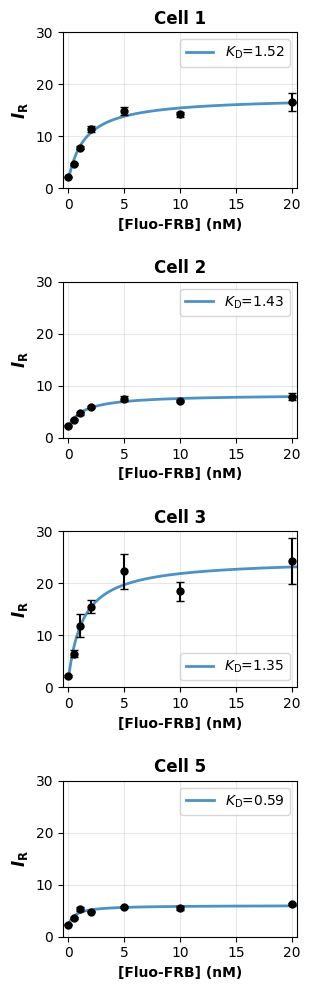


=== Plotting Ratio: OLS method ===
    label  additive      mean        sd  nZ
0       1       0.0  0.052590  0.004375   4
1       1       0.5  0.105983  0.005775   4
2       1       1.0  0.165746  0.003395   4
3       1       2.0  0.235097  0.013387   4
4       1       5.0  0.301622  0.009439   4
5       1      10.0  0.313221  0.020473   4
6       1      20.0  0.359816  0.004381   4
7       2       0.0  0.070668  0.007161   4
8       2       0.5  0.109128  0.003849   4
9       2       1.0  0.152351  0.014351   4
10      2       2.0  0.199899  0.026572   4
11      2       5.0  0.252775  0.013158   4
12      2      10.0  0.255648  0.011139   4
13      2      20.0  0.276922  0.009618   4
14      3       0.0  0.044027  0.003503   4
15      3       0.5  0.150101  0.004920   4
16      3       1.0  0.270041  0.024525   4
17      3       2.0  0.420367  0.037585   4
18      3       5.0  0.513348  0.027357   4
19      3      10.0  0.549444  0.031530   4
20      3      20.0  0.567116  0.058818 

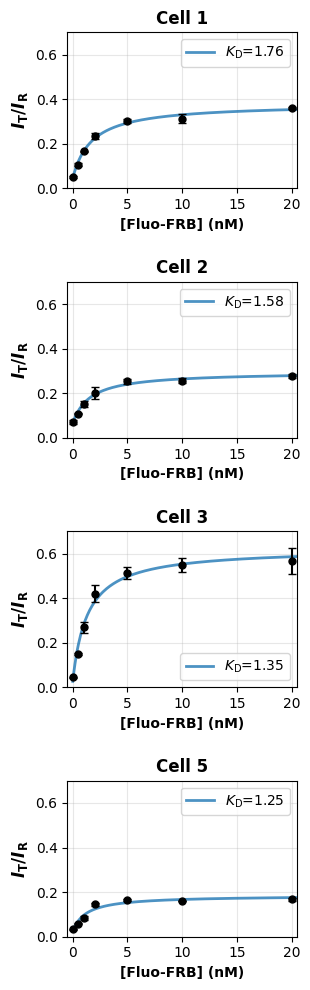

In [ ]:

# === 3) Per-cell Langmuir fits & plots ===
Lmin, Lmax = -0.5, 20.5


print("\n=== Method 2: OLS, absolute_sigma=False ===")
fit_FRB_ols, curves_FRB_ols, resid_FRB_ols = fit_per_cell(
    df, 'FRB', Lmin, Lmax, return_residuals=True, use_weights=False, absolute_sigma=False)
fit_ratio_ols, curves_ratio_ols, resid_ratio_ols = fit_per_cell(
    df, 'ratio', Lmin, Lmax, return_residuals=True, use_weights=False, absolute_sigma=False)


print("\n=== Plotting FRB: OLS method ===")
small_multiples_from_fits(df, fit_FRB_ols, 'FRB', Lmin, Lmax)

print("\n=== Plotting Ratio: OLS method ===")
small_multiples_from_fits(df, fit_ratio_ols, 'ratio', Lmin, Lmax)